In [1]:
import pandas as pd

In [2]:
import matplotlib
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [144]:
import scipy

In [4]:
from scipy import stats

In [5]:
import os

In [6]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn import preprocessing

In [7]:
from joblib import Parallel, delayed
from sklearn.utils import resample
import datetime

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score
from sklearn.utils import shuffle

In [9]:
'''
This package implements the statistical tools for quantifying the stability of feature selection as given in [1].
It includes 5 functions that provide:
    - the stability estimate of a feature selection procedure given its outputs;
    - the variance of the stability estimate;
    - a (1-alpha)- approximate confidence intervals for the population stability;
    - a null hypothesis test allowing to compare the population stability of a feature selection procedure to 
      a given value.
    - a null hypothesis test allowing to compare the population stabilities of two feature selection procedures.

[1] On the Stability of Feature Selection. Sarah Nogueira, Konstantinos Sechidis, Gavin Brown. 
    Journal of Machine Learning Reasearch (JMLR). 2017.

You can find a full demo using this package at:
http://htmlpreview.github.io/?https://github.com/nogueirs/JMLR2017/blob/master/python/stabilityDemo.html

NB: This package requires the installation of the packages: numpy, scipy and math

'''

import numpy as np
from scipy.stats import norm
import math


def getStability(Z):
    ''' 
    Let us assume we have M>1 feature sets and d>0 features in total.
    This function computes the stability estimate as given in Definition 4 in  [1].
    
    INPUT: A BINARY matrix Z (given as a list or as a numpy.ndarray of size M*d).
           Each row of the binary matrix represents a feature set, where a 1 at the f^th position 
           means the f^th feature has been selected and a 0 means it has not been selected.
           
    OUTPUT: The stability of the feature selection procedure
    '''
    Z=checkInputType(Z)
    M,d=Z.shape
    hatPF=np.mean(Z,axis=0)
    kbar=np.sum(hatPF)
    denom=(kbar/d)*(1-kbar/d)
    return 1-(M/(M-1))*np.mean(np.multiply(hatPF,1-hatPF))/denom

def getVarianceofStability(Z):
    '''
    Let us assume we have M>1 feature sets and d>0 features in total.
    This function computes the stability estimate and its variance as given in [1].
    
    INPUT: A BINARY matrix Z (given as a list or as a numpy.ndarray of size M*d, raises a ValueError exception otherwise).
           Each row of the binary matrix represents a feature set, where a 1 at the f^th position 
           means the f^th feature has been selected and a 0 means it has not been selected.
           
    OUTPUT: A dictionnary where the key 'stability' provides the corresponding stability value #
            and where the key 'variance' provides the variance of the stability estimate
    '''
    Z=checkInputType(Z) # check the input Z is of the right type
    M,d=Z.shape # M is the number of feature sets and d the total number of features
    hatPF=np.mean(Z,axis=0) # hatPF is a numpy.array with the frequency of selection of each feature
    kbar=np.sum(hatPF) # kbar is the average number of selected features over the M feature sets
    k=np.sum(Z,axis=1) # k is a numpy.array with the number of features selected on each one of the M feature sets
    denom=(kbar/d)*(1-kbar/d) 
    stab=1-(M/(M-1))*np.mean(np.multiply(hatPF,1-hatPF))/denom # the stability estimate
    phi=np.zeros(M)
    for i in range(M):
        phi[i]=(1/denom)*(np.mean(np.multiply(Z[i,],hatPF))-(k[i]*kbar)/d**2+(stab/2)*((2*k[i]*kbar)/d**2-k[i]/d-kbar/d+1))
    phiAv=np.mean(phi)
    variance=(4/M**2)*np.sum(np.power(phi-phiAv,2)) # the variance of the stability estimate as given in [1]
    return {'stability':stab,'variance':variance}

def confidenceIntervals(Z,alpha=0.05,res={}):
    '''
    Let us assume we have M>1 feature sets and d>0 features in total.
    This function provides the stability estimate and the lower and upper bounds of the (1-alpha)- approximate confidence 
    interval as given by Corollary 9 in [1]
    
    INPUTS: - A BINARY matrix Z (given as a list or as a numpy.ndarray of size M*d, raises a ValueError exception otherwise). 
              Each row of the binary matrix represents a feature set, where a 1 at the f^th position 
              means the f^th feature has been selected and a 0 means it has not been selected.
            - alpha is an optional argument corresponding to the level of significance for the confidence interval 
              (default is 0.05), e.g. alpha=0.05 give the lower and upper bound of for a (1-alpha)=95% confidence interval.
            - In case you already computed the stability estimate of Z using the function getVarianceofStability(Z), 
              you can provide theresult (a dictionnary) as an optional argument to this function for faster computation.
           
    OUTPUT: - A dictionnary where the key 'stability' provides the corresponding stability value, where:
                  - the key 'variance' provides the variance of the stability estimate;
                  - the keys 'lower' and 'upper' respectively give the lower and upper bounds 
                    of the (1-alpha)-confidence interval.
    '''
    Z=checkInputType(Z) # check the input Z is of the right type
    ## we check if values of alpha between ) and 1
    if alpha>=1 or alpha<=0:
        raise ValueError('The level of significance alpha should be a value >0 and <1')
    if len(res)==0: 
        res=getVarianceofStability(Z) # get a dictionnary with the stability estimate and its variance
    lower=res['stability']-norm.ppf(1-alpha/2)*math.sqrt(res['variance']) # lower bound of the confidence interval at a level alpha
    upper=res['stability']+norm.ppf(1-alpha/2)*math.sqrt(res['variance']) # upper bound of the confidence interval 
    return {'stability':res['stability'],'lower':lower,'upper':upper}

## this tests whether the true stability is equal to a given value stab0
def hypothesisTestV(Z,stab0,alpha=0.05):
    '''
    Let us assume we have M>1 feature sets and d>0 features in total.
    This function implements the null hypothesis test in [1] that test whether the population stability is greater 
    than a given value stab0.
    
    INPUTS:- A BINARY matrix Z (given as a list or as a numpy.ndarray of size M*d, raises a ValueError exception otherwise).
             Each row of the binary matrix represents a feature set, where a 1 at the f^th position
             means the f^th feature has been selected and a 0 means it has not been selected. 
           - stab0 is the value we want to compare the stability of the feature selection to.
           - alpha is an optional argument corresponding to the level of significance of the null hypothesis test 
             (default is 0.05).
           
    OUTPUT: A dictionnary with:
            - a boolean value for key 'reject' equal to True if the null hypothesis is rejected and to False otherwise
            - a float for the key 'V' giving the value of the test statistic 
            - a float giving for the key 'p-value' giving the p-value of the hypothesis test
    '''
    Z=checkInputType(Z) # check the input Z is of the right type
    res=getVarianceofStability(Z)
    V=(res['stability']-stab0)/math.sqrt(res['variance'])
    zCrit=norm.ppf(1-alpha)
    if V>=zCrit: reject=True
    else: reject=False
    pValue=1-norm.cdf(V)
    return {'reject':reject,'V':V,'p-value':pValue}

# this tests the equality of the stability of two algorithms
def hypothesisTestT(Z1,Z2,alpha=0.05):
    '''
    Let us assume we have M>1 feature sets and d>0 features in total.
    This function implements the null hypothesis test of Theorem 10 in [1] that test whether 
    two population stabilities are identical.
    
    INPUTS:- Two BINARY matrices Z1 and Z2 (given as lists or as numpy.ndarray objects of size M*d).
             Each row of the binary matrix represents a feature set, where a 1 at the f^th position 
             means the f^th feature has been selected and a 0 means it has not been selected. 
           - alpha is an optional argument corresponding to the level of significance of the null 
             hypothesis test (default is 0.05)
           
    OUTPUT: A dictionnary with:
            - a boolean value for key 'reject' equal to True if the null hypothesis is rejected and to False otherwise
            - a float for the key 'T' giving the value of the test statistic 
            - a float giving for the key 'p-value' giving the p-value of the hypothesis test
    '''
    Z1=checkInputType(Z1) # check the input Z1 is of the right type
    Z2=checkInputType(Z2) # check the input Z2 is of the right type
    res1=getVarianceofStability(Z1)
    res2=getVarianceofStability(Z2)
    stab1=res1['stability']
    stab2=res2['stability']
    var1=res1['variance']
    var2=res2['variance']
    T=(stab2-stab1)/math.sqrt(var1+var2)
    zCrit=norm.ppf(1-alpha/2) 
    ## the cumulative inverse of the gaussian at 1-alpha/2
    if(abs(T)>=zCrit):
        reject=True
        #print('Reject H0: the two algorithms have different population stabilities')
    else:
        reject=False
        #print('Do not reject H0')
    pValue=2*(1-norm.cdf(abs(T)))
    return {'reject':reject,'T':T,'p-value':pValue}

def checkInputType(Z):
    ''' This function checks that Z is of the rigt type and dimension.
        It raises an exception if not.
        OUTPUT: The input Z as a numpy.ndarray
    '''
    ### We check that Z is a list or a numpy.array
    if isinstance(Z,list):
        Z=np.asarray(Z)
    elif not isinstance(Z,np.ndarray):
        raise ValueError('The input matrix Z should be of type list or numpy.ndarray')
    ### We check if Z is a matrix (2 dimensions)
    if Z.ndim!=2:
        raise ValueError('The input matrix Z should be of dimension 2')
    return Z


def getBootstrapSample(data, labels):
    '''
    This function takes as input the data and labels and returns
    a bootstrap sample of the data, as well as its out-of-bag (OOB) data

    INPUTS:
    - data is a 2-dimensional numpy.ndarray where rows are examples and columns are features
    - labels is a 1-dimansional numpy.ndarray giving the label of each example in data

    OUPUT:
    - a dictionnary where:
          - key 'bootData' gives a 2-dimensional numpy.ndarray which is a bootstrap sample of data
          - key 'bootLabels' is a 1-dimansional numpy.ndarray giving the label of each example in bootData
          - key 'OOBData' gives a 2-dimensional numpy.ndarray the OOB examples
          - key 'OOBLabels' is a 1-dimansional numpy.ndarray giving the label of each example in OOBData
    '''
    m, d = data.shape
    if m != len(labels):
        raise ValueError('The data and labels should have a same number of rows.')
    ind = np.random.choice(range(m), size=m, replace=True)
    OOBind = np.setdiff1d(range(m), ind, assume_unique=True)
    bootData = data[ind,]
    bootLabels = labels[ind]
    OOBData = data[OOBind,]
    OOBLabels = labels[OOBind]
    return {'bootData': bootData, 'bootLabels': bootLabels, 'OOBData': OOBData, 'OOBLabels': OOBLabels}


In [10]:
def convert_to_vect(Q,R,S,T):
    resp=np.empty((0,4))
    end:Boolean= False
    idx_q=0    
    idx_r=0
    idx_s=0
    idx_t=0

    
    while not end:
        try:
            q=Q[idx_q]
            r=R[idx_r]
            s=S[idx_s]
            t=T[idx_t]
        except IndexError:
                end=True
                pass    
       
        arr=np.array([q,r,s,t],dtype=int)
        if not (q <= r and  r <=s and s <=t) :#and q < x_complex and t > x_complex :
            arr=np.array([-1,-1,-1,-1],dtype=int)
            print("no")
            
        else:
            resp=np.vstack((resp,arr))           
            
        if idx_q+1<len(Q):
            idx_q=idx_q+1
        else:
            end=True
        if   idx_r+1<len(R):        
            idx_r=idx_r+1
        else:
            end=True    
        if   idx_s+1<len(S):        
            idx_s=idx_s+1
        else:
            end= True
        if   idx_t+1<len(S):        
            idx_t=idx_t+1
        else:
            end= True    
    return resp

In [11]:
files= os.listdir('./signals/died/with_missing')

In [12]:
files_not_died= os.listdir('./signals/not_died/with_missing')

In [13]:
files_dist=list(filter( lambda x: '_peaks' in x, files))

In [14]:
files_dist_2=list(filter( lambda x: '_peaks' in x, files_not_died))

In [15]:
def to_df_with_col(path):
    df=pd.read_pickle(path)
    df['died']="/died/" in path
    df['filename']=path
    return df

In [16]:
frames= [to_df_with_col('./signals/died/with_missing/'+f) for f in files_dist]
frames2= [to_df_with_col('./signals/not_died/with_missing/'+f) for f in files_dist_2]

In [17]:
result = pd.concat(frames+frames2)

In [18]:
result.head()

,R,R_val,RR,RR_val,Q,Q_val,S,S_val,T,T_val,died,filename
complex_id,,,,,,,,,,,,
1,88.0,0.298953,NaN,NaN,81.0,-0.118281,100.0,-0.269625,109.0,0.185511,True,./signals/died/with_missing/p000491-2170-04-03...
2,196.0,0.273716,108.0,-0.025238,189.0,-0.112431,207.0,-0.267308,216.0,0.190225,True,./signals/died/with_missing/p000491-2170-04-03...
3,303.0,0.274182,107.0,0.000467,296.0,-0.091532,314.0,-0.269447,324.0,0.211441,True,./signals/died/with_missing/p000491-2170-04-03...
4,411.0,0.271524,108.0,-0.002659,404.0,-0.115924,422.0,-0.271142,431.0,0.185099,True,./signals/died/with_missing/p000491-2170-04-03...
5,518.0,0.295205,107.0,0.023682,511.0,-0.124722,529.0,-0.272963,538.0,0.202816,True,./signals/died/with_missing/p000491-2170-04-03...


In [19]:
result['QR']=result['R'] - result['Q']
result['RS']=result['S'] - result['R']
result['ST']=result['T'] - result['S']
 

In [20]:
result=result[~result.R.isna()]
result=result[~result.RR.isna()]
result=result[result.RR>=0]

In [21]:
result.isnull().sum(axis = 0)

R               0
R_val           0
RR              0
RR_val          0
Q               7
Q_val           7
S              11
S_val          11
T           19420
T_val       19420
died            0
filename        0
QR              7
RS             11
ST          19420
dtype: int64

In [22]:
result.shape

(14389459, 15)

In [23]:
no_dups=result.drop_duplicates(subset=['RR','QR', 'RS','ST','T'], keep='last', inplace=False)

In [24]:
no_dups.shape

(14330452, 15)

In [25]:
no_dups.groupby('died').count()['RR']

died
False    10320815
True      4009637
Name: RR, dtype: int64

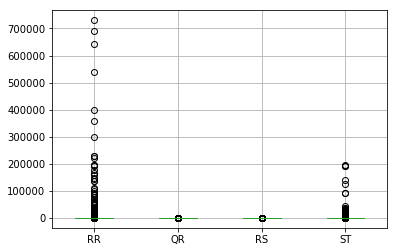

In [26]:
no_dups[['RR','QR', 'RS','ST']].boxplot()

### Hay RR que son muy altos, puede deberse a que el segmento de señal analizado no detecta latidos y salta, por lo tanto se deben ignorar para el análisis, suponiendo que el mínimo HR es 40 bpm, los pícos R deberían estar como máximo separados por 1.5 segundos  60s / (40 b/min), por lo tanto quitamos para el análisis de cluster los elementos que tengan más de 1.5* fs(125)  de distancia entre picos (189)

In [27]:
no_dups=no_dups[no_dups.RR<189]

In [28]:
len(no_dups)

14306737

In [29]:
no_dups.groupby('died').count()['RR']

died
False    10305803
True      4000934
Name: RR, dtype: int64

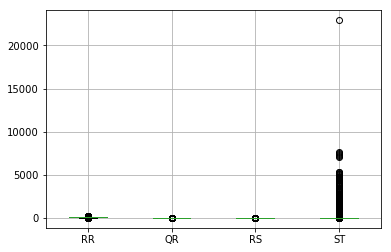

In [30]:
no_dups[['RR','QR', 'RS','ST']].boxplot()

### Persisten problemas con la calidad de los ST, esto se puede deber a que el pico T no esta siendo debidamente identificado dentro del complejo y esta siendo detectado en picos de más adelante. Se descartan estos latidos para continuar el análisis.

In [32]:
no_dups.ST.describe()

count    1.430337e+07
mean     1.669774e+01
std      1.408851e+01
min      4.000000e+00
25%      1.200000e+01
50%      1.300000e+01
75%      2.100000e+01
max      2.291700e+04
Name: ST, dtype: float64

In [33]:
per_75_IQR=np.percentile(no_dups.ST.dropna(),75)+1.5*stats.iqr(no_dups.ST.dropna())
per_75_IQR

34.5

In [34]:
np.sum(no_dups.ST>=per_75_IQR)

757625

In [35]:
no_dups=no_dups[no_dups.ST<per_75_IQR]

In [36]:
len(no_dups)

13545747

In [37]:
no_dups.groupby('died').count()['ST']

died
False    9670981
True     3874766
Name: ST, dtype: int64

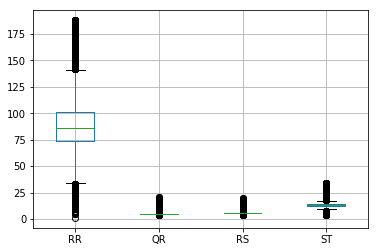

In [38]:
no_dups[['RR','QR', 'RS','ST']].boxplot()

## Comparamos individualmente las variables independientes frente a la variable objetivo

In [39]:
from scipy.stats import ttest_ind

## RR

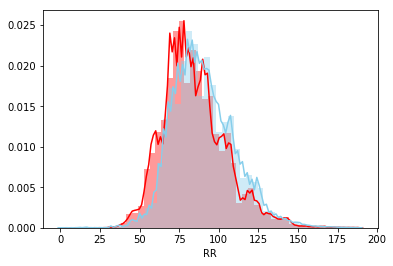

In [40]:
sns.distplot(no_dups[no_dups['died']==True].RR, color='red', label='died')
sns.distplot(no_dups[no_dups['died']==False].RR, color='skyblue', label='not died')

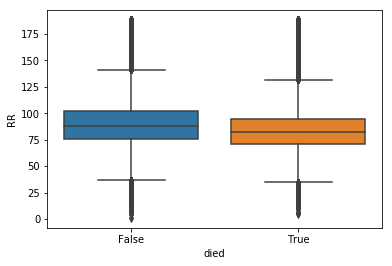

In [41]:
sns.boxplot(data=no_dups,y='RR', x='died')

In [42]:
#Null is equal averages, discarded
ttest_ind(no_dups[no_dups['died']==True].RR,no_dups[no_dups['died']==False].RR, equal_var=False)

Ttest_indResult(statistic=-492.4343534687144, pvalue=0.0)

## QR

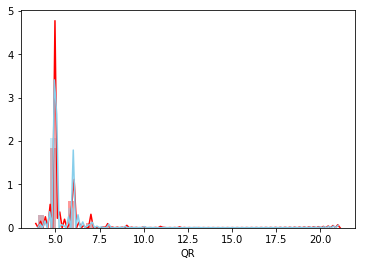

In [43]:
sns.distplot(no_dups[no_dups['died']==True].QR, color='red', label='died')
sns.distplot(no_dups[no_dups['died']==False].QR, color='skyblue', label='not died')

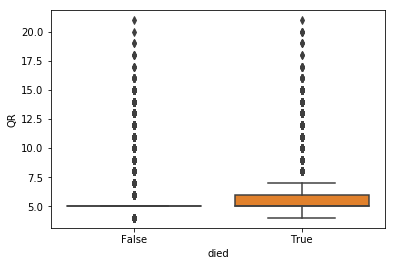

In [44]:
sns.boxplot(data=no_dups,y='QR', x='died')

In [45]:
#Null is equal averages, discarded
ttest_ind(no_dups[no_dups['died']==True].QR,no_dups[no_dups['died']==False].QR, equal_var=False)

Ttest_indResult(statistic=242.39117956818782, pvalue=0.0)

## RS

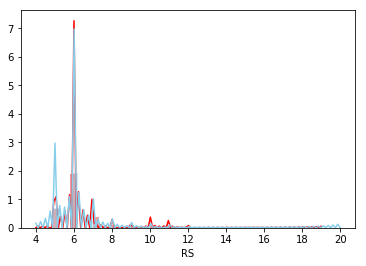

In [46]:
sns.distplot(no_dups[no_dups['died']==True].RS, color='red', label='died')
sns.distplot(no_dups[no_dups['died']==False].RS, color='skyblue', label='not died')

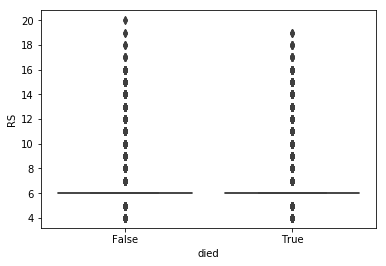

In [47]:
sns.boxplot(data=no_dups,y='RS', x='died')

In [48]:
#Null is equal averages, discarded
ttest_ind(no_dups[no_dups['died']==True].RS,no_dups[no_dups['died']==False].RS, equal_var=False)

Ttest_indResult(statistic=325.6491775371065, pvalue=0.0)

## ST

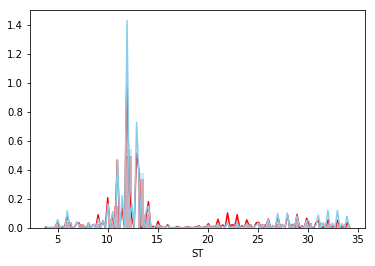

In [49]:
sns.distplot(no_dups[no_dups['died']==True].ST, color='red', label='died')
sns.distplot(no_dups[no_dups['died']==False].ST, color='skyblue', label='not died')

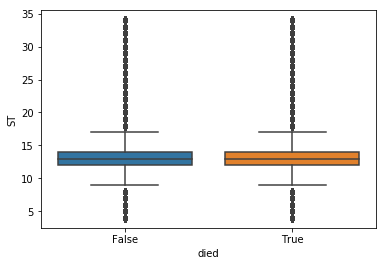

In [50]:
sns.boxplot(data=no_dups,y='ST', x='died')

In [51]:
#Null is equal averages, discarded
ttest_ind(no_dups[no_dups['died']==True].ST,no_dups[no_dups['died']==False].ST, equal_var=False)

Ttest_indResult(statistic=-51.25991705246479, pvalue=0.0)

## T

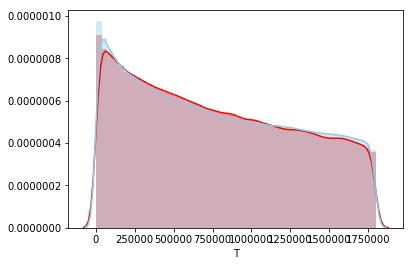

In [52]:
sns.distplot(no_dups[no_dups['died']==True]['T'], color='red', label='died')
sns.distplot(no_dups[no_dups['died']==False]['T'], color='skyblue', label='not died')

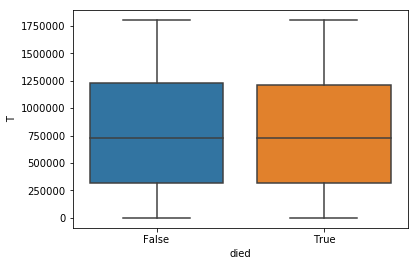

In [53]:
sns.boxplot(data=no_dups,y='T', x='died')

In [54]:
#Null is equal averages, discarded
ttest_ind(no_dups[no_dups['died']==True]['T'],no_dups[no_dups['died']==False]['T'], equal_var=False)

Ttest_indResult(statistic=-13.287478066778165, pvalue=2.7394555060403106e-40)

In [55]:
no_dups.shape

(13545747, 15)

### Quitamos T ya que no parece tener diferencia para el fenómeno

In [56]:
no_dups=no_dups.drop_duplicates(subset=['RR','QR', 'RS','ST'])

In [57]:
no_dups.isnull().sum(axis = 0)

R           0
R_val       0
RR          0
RR_val      0
Q           0
Q_val       0
S           0
S_val       0
T           0
T_val       0
died        0
filename    0
QR          0
RS          0
ST          0
dtype: int64

In [58]:
no_dups[['RR','QR', 'RS','ST']].describe()

,RR,QR,RS,ST
count,114129.000000,114129.000000,114129.000000,114129.00000
mean,91.547223,6.695240,8.143934,17.93651
std,34.231179,2.060966,2.510968,8.36643
min,1.000000,4.000000,4.000000,4.00000
25%,66.000000,5.000000,6.000000,11.00000
50%,89.000000,6.000000,8.000000,17.00000
75%,115.000000,8.000000,10.000000,25.00000
max,188.000000,21.000000,20.000000,34.00000


In [59]:
no_dups.shape

(114129, 15)

## Aplicamos estadarización de features

In [60]:
scaler= preprocessing.RobustScaler().fit(no_dups[['RR','QR', 'RS','ST']])

In [61]:
X=scaler.transform(no_dups[['RR','QR', 'RS','ST']])

In [62]:
X

array([[ 0.3877551 ,  0.33333333,  0.75      , -0.57142857],
       [ 0.36734694,  0.33333333,  0.75      , -0.5       ],
       [ 0.36734694,  0.33333333,  0.75      , -0.57142857],
       ...,
       [-0.57142857,  0.66666667,  0.25      , -0.28571429],
       [-1.20408163, -0.33333333, -0.25      ,  0.64285714],
       [-0.57142857, -0.33333333,  0.75      ,  0.28571429]])

In [63]:
pd.DataFrame(X, columns=['RR','QR', 'RS','ST']).describe()

,RR,QR,RS,ST
count,114129.000000,114129.000000,114129.000000,114129.000000
mean,0.051984,0.231747,0.035983,0.066894
std,0.698595,0.686989,0.627742,0.597602
min,-1.795918,-0.666667,-1.000000,-0.928571
25%,-0.469388,-0.333333,-0.500000,-0.428571
50%,0.000000,0.000000,0.000000,0.000000
75%,0.530612,0.666667,0.500000,0.571429
max,2.020408,5.000000,3.000000,1.214286


In [64]:
from sklearn.decomposition import PCA

In [65]:
pca = PCA()
x_new = pca.fit_transform(X)

In [66]:
help(pca)

Help on PCA in module sklearn.decomposition.pca object:

class PCA(sklearn.decomposition.base._BasePCA)
 |  PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
 |  
 |  Principal component analysis (PCA)
 |  
 |  Linear dimensionality reduction using Singular Value Decomposition of the
 |  data to project it to a lower dimensional space.
 |  
 |  It uses the LAPACK implementation of the full SVD or a randomized truncated
 |  SVD by the method of Halko et al. 2009, depending on the shape of the input
 |  data and the number of components to extract.
 |  
 |  It can also use the scipy.sparse.linalg ARPACK implementation of the
 |  truncated SVD.
 |  
 |  Notice that this class does not support sparse input. See
 |  :class:`TruncatedSVD` for an alternative with sparse data.
 |  
 |  Read more in the :ref:`User Guide <PCA>`.
 |  
 |  Parameters
 |  ----------
 |  n_components : int, float, None or string
 |      Number of co

In [67]:
print( pca.components_ )

[[-0.56617236  0.7575647   0.31704804 -0.0708881 ]
 [ 0.80064933  0.43975697  0.32394304 -0.2462425 ]
 [ 0.01867273 -0.2425563   0.75034586  0.61465345]
 [ 0.19509187  0.41698439 -0.48116789  0.74601652]]


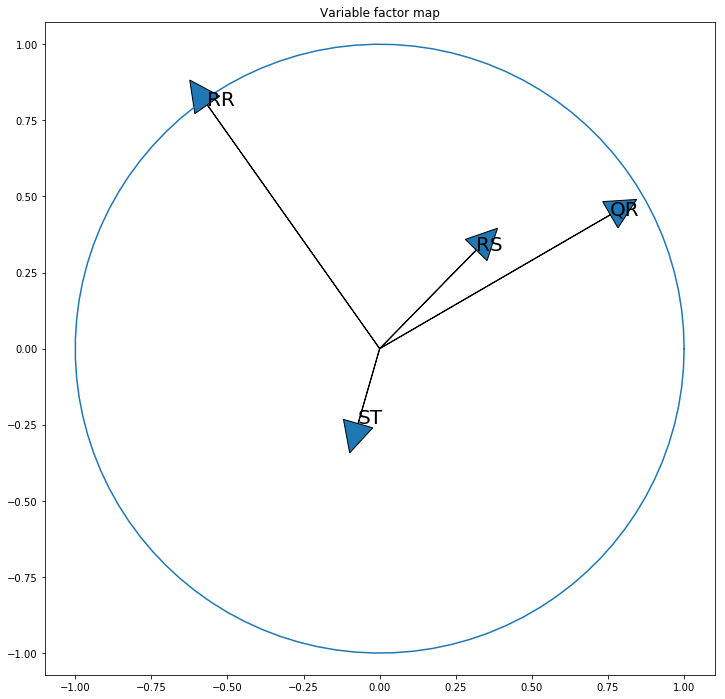

In [68]:
(fig, ax) = plt.subplots(figsize=(12, 12))
cols=['RR','QR', 'RS','ST']
for i in range(0, len(pca.components_)):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.1,
             head_length=0.1)
    plt.text(pca.components_[0, i] ,
         pca.components_[1, i] ,
         cols[i], fontsize=20)

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
ax.set_title('Variable factor map')
plt.show()

In [69]:
print(pca.explained_variance_ratio_)

[0.30560304 0.28072357 0.2242356  0.18943779]


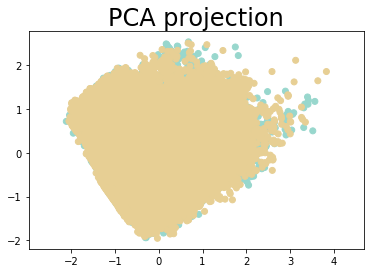

In [70]:
plt.scatter(x_new[:, 0], x_new[:, 1], c=[sns.color_palette("BrBG", 2)[x] for x in no_dups['died']])
plt.gca().set_aspect('equal', 'datalim')
plt.title('PCA projection', fontsize=24);

In [71]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.externals.joblib import Parallel, delayed


### HDBSCAN

In [72]:
import hdbscan

In [73]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, gen_min_span_tree=True)
clusterer.fit(X)

C:\Users\AndresM\Anaconda3\envs\HR_Analysis\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\AndresM\Anaconda3\envs\HR_Analysis\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\AndresM\Anaconda3\envs\HR_Analysis\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\AndresM\Anaconda3\envs\HR_Analysis\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=100, min_samples=None, p=None,
    prediction_data=False)

In [74]:
matplotlib.rc('figure', figsize=[20,20])

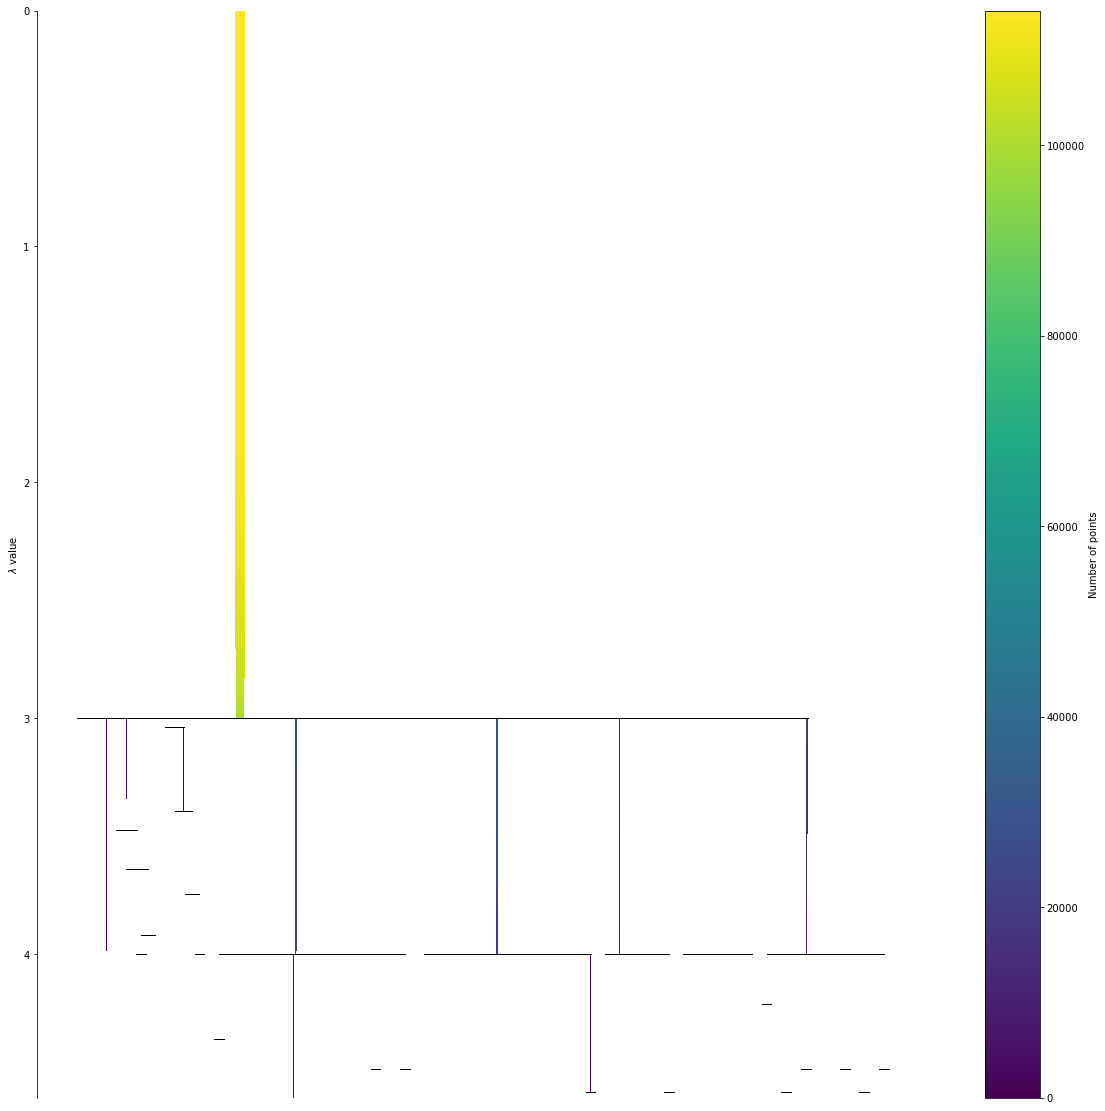

In [75]:
clusterer.condensed_tree_.plot()

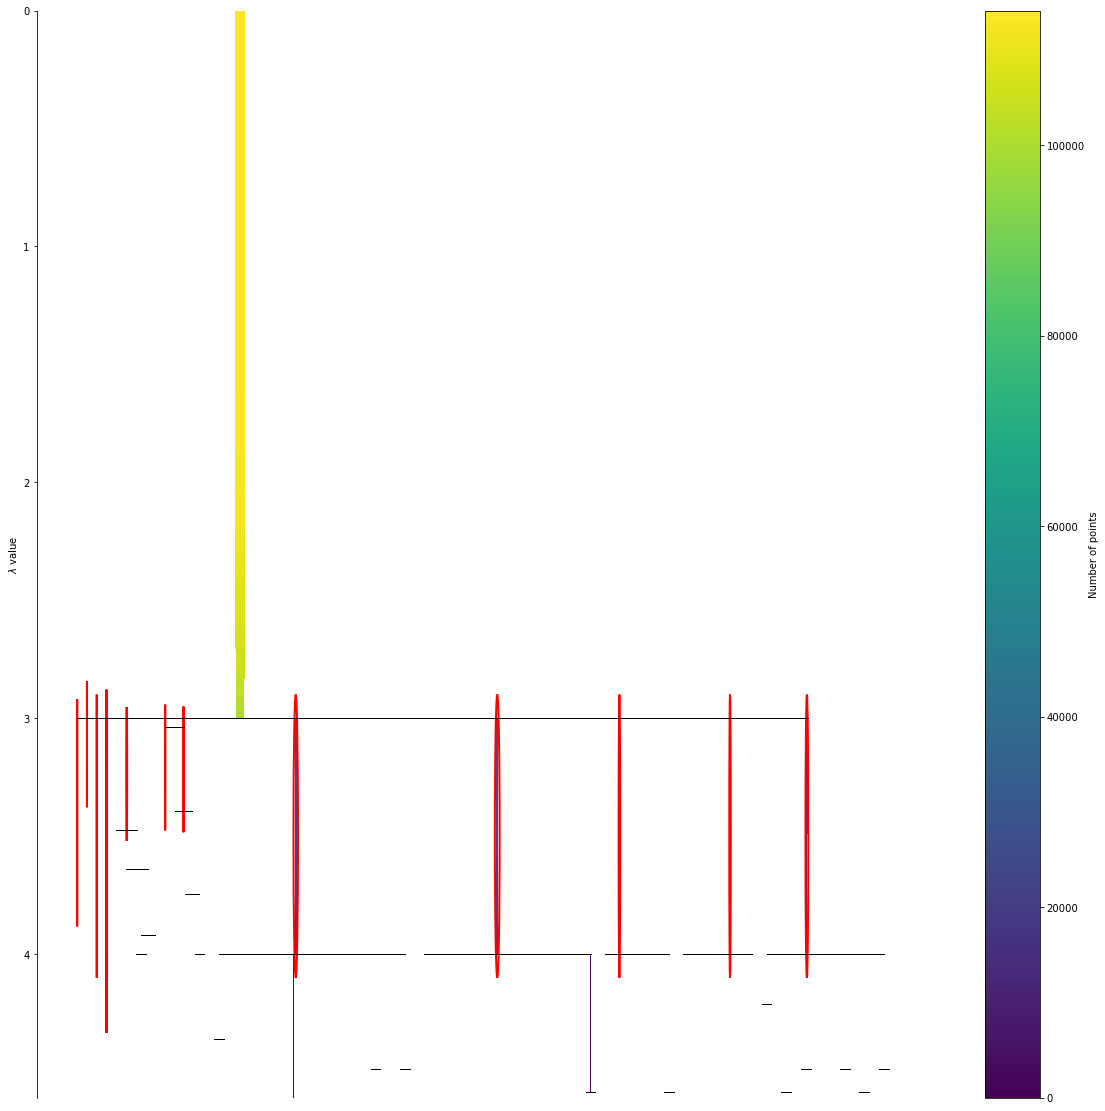

In [76]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [77]:
np.unique(clusterer.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64),
 array([14826,   493,   150,   983,  1665,  5212,  8643, 26116, 27963,
         8582, 16384,   182,  2930], dtype=int64))

In [78]:
clusterer.probabilities_

array([1.        , 1.        , 1.        , ..., 1.        , 0.89806271,
       1.        ])

In [79]:
no_dups['labels']=clusterer.labels_

In [80]:
no_dups['lab']=no_dups.labels.map(lambda x: chr(97+x) if x!=-1 else ' ')

In [81]:
no_dups

,R,R_val,RR,RR_val,Q,Q_val,S,S_val,T,T_val,died,filename,QR,RS,ST,labels,lab
complex_id,,,,,,,,,,,,,,,,,
2,196.0,0.273716,108.0,-0.025238,189.0,-0.112431,207.0,-0.267308,216.0,0.190225,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9,j
3,303.0,0.274182,107.0,0.000467,296.0,-0.091532,314.0,-0.269447,324.0,0.211441,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,10.0,9,j
5,518.0,0.295205,107.0,0.023682,511.0,-0.124722,529.0,-0.272963,538.0,0.202816,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9,j
6,624.0,0.378144,106.0,0.082939,618.0,-0.130054,632.0,-0.341294,643.0,0.148288,True,./signals/died/with_missing/p000491-2170-04-03...,6.0,8.0,11.0,7,h
7,733.0,0.265643,109.0,-0.112502,726.0,-0.103380,744.0,-0.259310,753.0,0.189169,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9,j
9,957.0,-0.396530,117.0,-0.666427,948.0,0.310781,967.0,0.197868,980.0,-0.130343,True,./signals/died/with_missing/p000491-2170-04-03...,9.0,10.0,13.0,4,e
10,1053.0,0.260240,96.0,0.656770,1047.0,-0.099309,1060.0,-0.235120,1071.0,0.100048,True,./signals/died/with_missing/p000491-2170-04-03...,6.0,7.0,11.0,7,h
11,1172.0,-0.391380,119.0,-0.651620,1163.0,0.289768,1182.0,0.212356,1195.0,-0.135169,True,./signals/died/with_missing/p000491-2170-04-03...,9.0,10.0,13.0,4,e
12,1279.0,-0.415892,107.0,-0.024511,1271.0,0.328723,1289.0,0.193760,1301.0,-0.124304,True,./signals/died/with_missing/p000491-2170-04-03...,8.0,10.0,12.0,8,i


In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize']=(20,10)

In [83]:
X_sample=no_dups[['RR','QR', 'RS','ST','labels']].sample(5000)

In [84]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=10,n_iter=5000).fit_transform(X_sample[['RR','QR', 'RS','ST']])


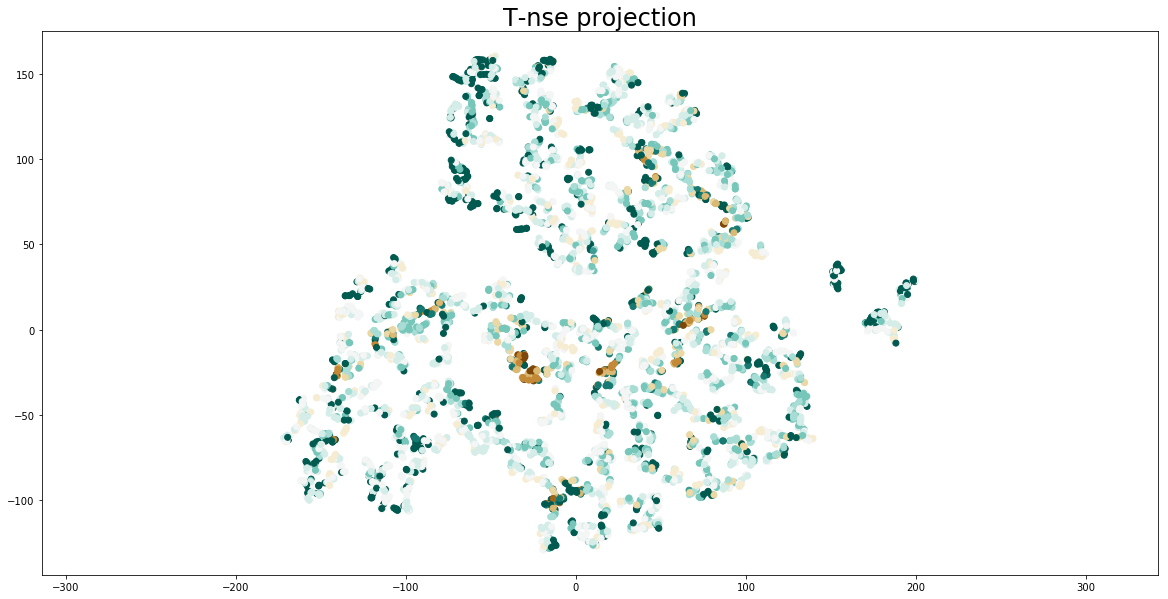

In [85]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=[sns.color_palette("BrBG",  X_sample['labels'].nunique())[x] for x in X_sample['labels']])
plt.gca().set_aspect('equal', 'datalim')
plt.title('T-nse projection', fontsize=24);

### convert files to Strings

In [86]:
result=result.merge(no_dups[['RR','QR','RS','ST','labels']], how='left')

In [87]:
result.head(20)

,R,R_val,RR,RR_val,Q,Q_val,S,S_val,T,T_val,died,filename,QR,RS,ST,labels
0,196.0,0.273716,108.0,-0.025238,189.0,-0.112431,207.0,-0.267308,216.0,0.190225,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9.0
1,303.0,0.274182,107.0,0.000467,296.0,-0.091532,314.0,-0.269447,324.0,0.211441,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,10.0,9.0
2,411.0,0.271524,108.0,-0.002659,404.0,-0.115924,422.0,-0.271142,431.0,0.185099,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9.0
3,518.0,0.295205,107.0,0.023682,511.0,-0.124722,529.0,-0.272963,538.0,0.202816,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9.0
4,624.0,0.378144,106.0,0.082939,618.0,-0.130054,632.0,-0.341294,643.0,0.148288,True,./signals/died/with_missing/p000491-2170-04-03...,6.0,8.0,11.0,7.0
5,733.0,0.265643,109.0,-0.112502,726.0,-0.103380,744.0,-0.259310,753.0,0.189169,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9.0
6,840.0,0.269897,107.0,0.004254,833.0,-0.110853,851.0,-0.273851,861.0,0.208425,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,10.0,9.0
7,957.0,-0.396530,117.0,-0.666427,948.0,0.310781,967.0,0.197868,980.0,-0.130343,True,./signals/died/with_missing/p000491-2170-04-03...,9.0,10.0,13.0,4.0
8,1053.0,0.260240,96.0,0.656770,1047.0,-0.099309,1060.0,-0.235120,1071.0,0.100048,True,./signals/died/with_missing/p000491-2170-04-03...,6.0,7.0,11.0,7.0
9,1172.0,-0.391380,119.0,-0.651620,1163.0,0.289768,1182.0,0.212356,1195.0,-0.135169,True,./signals/died/with_missing/p000491-2170-04-03...,9.0,10.0,13.0,4.0


In [88]:
sum(result.labels.isna())

800727

In [89]:
#Fill long R
group_RR=clusterer.labels_.max()+1
result['labels']=result[['RR','labels']].apply(lambda x: group_RR if x['RR']>=189 else x['labels'],axis=1 )

In [90]:
# Q, S ,T  is null
result['labels']=result[['Q','labels']].apply(lambda x: group_RR+1 if np.isnan(x['Q']) else x['labels'],axis=1 )
result['labels']=result[['S','labels']].apply(lambda x: group_RR+2 if np.isnan(x['S']) else x['labels'],axis=1 )
result['labels']=result[['T','labels']].apply(lambda x: group_RR+3 if np.isnan(x['T']) else x['labels'],axis=1 )

In [91]:
# ST
result['labels']=result[['ST','labels']].apply(lambda x: group_RR+4 if x['ST']>=per_75_IQR else x['labels'],axis=1 )


In [92]:
sum(result.labels.isna())

0

In [93]:
result['labels'].fillna(-1, inplace=True)

In [94]:
result['labels']=result['labels'].astype(int)

In [107]:
result['lab']=result.labels.map(lambda x: chr(97+x) if not(x==group_RR or x==-1) else ' ')

In [105]:
np.unique(result.labels, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 15, 16]),
 array([  37222,    4393,    1414,   10117,   26691,   61929, 1326014,
        9227067, 2328667,  147910,  386284,     379,   30645,   16742,
          19420,  764565], dtype=int64))

In [108]:
np.unique(result.lab, return_counts=True)

(array([' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
        'p', 'q'], dtype=object),
 array([  53964,    4393,    1414,   10117,   26691,   61929, 1326014,
        9227067, 2328667,  147910,  386284,     379,   30645,   19420,
         764565], dtype=int64))

In [109]:
result.head(20)

,R,R_val,RR,RR_val,Q,Q_val,S,S_val,T,T_val,died,filename,QR,RS,ST,labels,lab
0,196.0,0.273716,108.0,-0.025238,189.0,-0.112431,207.0,-0.267308,216.0,0.190225,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9,j
1,303.0,0.274182,107.0,0.000467,296.0,-0.091532,314.0,-0.269447,324.0,0.211441,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,10.0,9,j
2,411.0,0.271524,108.0,-0.002659,404.0,-0.115924,422.0,-0.271142,431.0,0.185099,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9,j
3,518.0,0.295205,107.0,0.023682,511.0,-0.124722,529.0,-0.272963,538.0,0.202816,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9,j
4,624.0,0.378144,106.0,0.082939,618.0,-0.130054,632.0,-0.341294,643.0,0.148288,True,./signals/died/with_missing/p000491-2170-04-03...,6.0,8.0,11.0,7,h
5,733.0,0.265643,109.0,-0.112502,726.0,-0.103380,744.0,-0.259310,753.0,0.189169,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9,j
6,840.0,0.269897,107.0,0.004254,833.0,-0.110853,851.0,-0.273851,861.0,0.208425,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,10.0,9,j
7,957.0,-0.396530,117.0,-0.666427,948.0,0.310781,967.0,0.197868,980.0,-0.130343,True,./signals/died/with_missing/p000491-2170-04-03...,9.0,10.0,13.0,4,e
8,1053.0,0.260240,96.0,0.656770,1047.0,-0.099309,1060.0,-0.235120,1071.0,0.100048,True,./signals/died/with_missing/p000491-2170-04-03...,6.0,7.0,11.0,7,h
9,1172.0,-0.391380,119.0,-0.651620,1163.0,0.289768,1182.0,0.212356,1195.0,-0.135169,True,./signals/died/with_missing/p000491-2170-04-03...,9.0,10.0,13.0,4,e


In [110]:
results_agg=result.groupby('filename').agg({'lab':lambda x: x.sum()}).reset_index()

In [111]:
results_agg=results_agg.merge(result[['filename','died']].drop_duplicates(), on='filename' )

In [113]:
results_agg.head(20)

,filename,lab,died
0,./signals/died/with_missing/p000491-2170-04-03...,jjjjhjjeheijjh hhjijhjjlhjhhhjjjjhjjjjhjjijjjj...,True
1,./signals/died/with_missing/p000491-2170-04-04...,chcjqchhjdiqdiddcdcjgiddhdccihggjdcjddijqcdaic...,True
2,./signals/died/with_missing/p000593-2102-06-23...,ffgggggggggggggggggggggggfgggggggggggggggggggg...,True
3,./signals/died/with_missing/p000743-2111-02-14...,hhhhhgghhhghghghhhhhghhgghqhhhghjhhhhhlhhhhphh...,True
4,./signals/died/with_missing/p000743-2111-02-19...,hhhhhhhghhhhghhhhhhhhhhhhhhhgghhghgghgghhghhhh...,True
5,./signals/died/with_missing/p000773-2109-03-11...,fgfggggggggggfggggfggggggggggggfggfggggggggggg...,True
6,./signals/died/with_missing/p000871-2125-05-06...,ggggggggggggggghggggggggggghgggggggggggggggggg...,True
7,./signals/died/with_missing/p001049-2118-09-04...,gfgggggfgggggggggggggggggggghggggggggggggggggg...,True
8,./signals/died/with_missing/p001075-2175-02-24...,hgggggggggqghhhgggggggggggggqgggggggghgggggggg...,True
9,./signals/died/with_missing/p001092-2155-09-12...,hhhhhghhhggghhhhhhhhhhgghhhhhhhghhghhhhhghhhhh...,True


In [114]:
from nltk.tokenize import RegexpTokenizer

In [115]:
from nltk.util import ngrams

In [116]:
from collections import Counter

In [117]:
tokenizer = RegexpTokenizer('\S')

In [118]:
def tk(text):
    tokenizer = RegexpTokenizer('\S')
    return tokenizer.tokenize(text)

In [119]:
phrase_counter = Counter()
for l in results_agg.lab:
    tokens=tokenizer.tokenize(l)
    for phrase in ngrams(tokens, 2):
        phrase_counter[phrase] += 1
    for phrase in ngrams(tokens, 3):
        phrase_counter[phrase] += 1
    for phrase in ngrams(tokens, 4):
        phrase_counter[phrase] += 1
    for phrase in ngrams(tokens, 5):
        phrase_counter[phrase] += 1    

In [120]:
vocabulary=list(map( lambda x : ''.join(x[0]) ,phrase_counter.most_common(3000)))

In [121]:
len(vocabulary)

3000

In [122]:
results_agg.shape

(1374, 3)

In [123]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [124]:
tfidf = TfidfVectorizer(stop_words=[], tokenizer=tk, ngram_range=(1,6) )

In [125]:
transformed=tfidf.fit_transform(results_agg.lab)

In [126]:
dense=transformed.todense()

In [127]:
dense.shape

(1374, 164817)

In [128]:
features=tfidf.get_feature_names()

In [129]:
df_tfidf=pd.DataFrame(dense, index=results_agg.index, columns= tfidf.get_feature_names())

In [130]:
df_tfidf['label']=results_agg['died']

In [131]:
df_tfidf['label']

0        True
1        True
2        True
3        True
4        True
5        True
6        True
7        True
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18       True
19       True
20       True
21       True
22       True
23       True
24       True
25       True
26       True
27       True
28       True
29       True
        ...  
1344    False
1345    False
1346    False
1347    False
1348    False
1349    False
1350    False
1351    False
1352    False
1353    False
1354    False
1355    False
1356    False
1357    False
1358    False
1359    False
1360    False
1361    False
1362    False
1363    False
1364    False
1365    False
1366    False
1367    False
1368    False
1369    False
1370    False
1371    False
1372    False
1373    False
Name: label, Length: 1374, dtype: bool

In [132]:
from sklearn.model_selection import train_test_split

In [133]:
df_tfidf_train, df_tfidf_test = train_test_split( df_tfidf, test_size = .3, random_state = 2 )

In [134]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score

In [137]:
len(features)

164817

In [135]:
df_tfidf_train[features]

,a,a a,a a a,a a a a,a a a a a,a a a a a a,a a a a a c,a a a a a d,a a a a a h,a a a a a i,...,q q q q q e,q q q q q f,q q q q q g,q q q q q h,q q q q q i,q q q q q j,q q q q q k,q q q q q l,q q q q q p,q q q q q q
305,0.000000,0.000000,0.000000,0.00000,0.00000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1051,0.000000,0.000000,0.000000,0.00000,0.00000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.004627,0.011194,0.013230,0.000000,0.000000,0.0,0.000000,0.000000,0.431323
505,0.000000,0.000000,0.000000,0.00000,0.00000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
765,0.000000,0.000000,0.000000,0.00000,0.00000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
678,0.000000,0.000000,0.000000,0.00000,0.00000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000615,0.000364,0.000000,0.000000,0.0,0.000000,0.000216,0.003584
840,0.000000,0.000000,0.000000,0.00000,0.00000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1031,0.000000,0.000000,0.000000,0.00000,0.00000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.001310,0.001032,0.000000,0.000000,0.0,0.000000,0.000000,0.007732
93,0.000000,0.000000,0.000000,0.00000,0.00000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
969,0.000000,0.000000,0.000000,0.00000,0.00000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
866,0.000225,0.000000,0.000000,0.00000,0.00000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000164,0.001055,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.004918


In [138]:
df_tfidf_train['label']

305      True
1051    False
505     False
765     False
678     False
840     False
1031    False
93       True
969     False
866     False
690     False
451     False
1079    False
1335    False
197      True
681     False
568     False
128      True
949     False
1037    False
309      True
1067    False
281      True
200      True
717     False
701     False
665     False
999     False
911     False
823     False
        ...  
255      True
892     False
359     False
51       True
875     False
938     False
772     False
1126    False
1219    False
679     False
805     False
124      True
404     False
730     False
1311    False
831     False
1071    False
725     False
587     False
607     False
433     False
674     False
1287    False
360     False
1099    False
466     False
299      True
493     False
527     False
1192    False
Name: label, Length: 961, dtype: bool

In [139]:
coefs = dict()
f1_score_dict = dict()

In [141]:
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

In [149]:
def do_sample_iteration(alpha, data_train_ensa, features, i):
    print(f'Iteration {i}')
    all_indexes = set(data_train_ensa.index)
    sampled_dataset = resample(data_train_ensa, replace=True)
    not_sampled_dataset = data_train_ensa.loc[list(all_indexes - set(sampled_dataset.index))]
    # model = SGDClassifier(loss='log', penalty='l1', alpha=alpha, max_iter=500, learning_rate='adaptive',
    #                      eta0=0.001, class_weight='balanced',  verbose=0, n_iter_no_change=10, random_state=0)
    model = LogisticRegression(penalty='l1', solver='liblinear', C=1 / alpha, max_iter=300, class_weight='balanced',
                               fit_intercept=False)
    model.fit(sampled_dataset[features], sampled_dataset['label'])
    coefs = model.coef_.flatten()
    bin_coefs = coefs != 0
    train_preds = model.predict(sampled_dataset[features])
    test_preds = model.predict(not_sampled_dataset[features])
    f_beta_train = fbeta_score(sampled_dataset['label'], train_preds, 1)
    f_beta_test = fbeta_score(not_sampled_dataset['label'], test_preds, 1)
    print(
        f'RESULTS: M:{i} alpha_:{alpha} f_beta_train:{f_beta_train} f_beta_test:{f_beta_test} '
        f'num_features {np.sum(bin_coefs)}')
    return {'i': i, 'coefs': coefs, 'bin_coefs': bin_coefs, 'f_beta_test': f_beta_test, 'f_beta_train': f_beta_train}


In [150]:
folds_results = pd.DataFrame(data=None,
                                 columns=['alpha', 'avg_f_beta', 'avg_f_beta_low', 'stability', 'stability_lower',
                                          'support'])
for alpha in alphas:
    print(alpha)
    print(datetime.datetime.now())
    M = 100
    Z = np.zeros((M, len(features)), dtype=np.int8)
    f_betas = {}
    val = Parallel(n_jobs=4)(delayed(do_sample_iteration)(alpha, df_tfidf_train, features, i) for i in range(M))
    print(val)
    for x in val:
        i = x['i']
        f_beta_train = x['f_beta_train']
        f_beta_test = x['f_beta_test']
        bin_coefs = x['bin_coefs']
        Z[i] = bin_coefs
        f_betas[i] = np.asarray([f_beta_train, f_beta_test]).flatten()

    print(datetime.datetime.now())
    f_betas_df = pd.DataFrame.from_dict(f_betas, orient='index', columns=['train', 'test'])
    avg_fbeta = f_betas_df['test'].mean()
    se = scipy.stats.sem(f_betas_df['test'])
    h = se * scipy.stats.t.ppf((1 + 0.95) / 2., len(f_betas_df['test']) - 1)
    avg_fbeta_low = avg_fbeta - h
    confidence_results = confidenceIntervals(Z)
    support = Z.mean(axis=0)
    folds_results = folds_results.append(
        {'alpha': alpha, 'avg_f_beta': avg_fbeta, 'avg_f_beta_low': avg_fbeta_low,
         'stability': confidence_results['stability'],
         'stability_lower': confidence_results['lower'],
         'support': support},
        ignore_index=True)

folds_results['l1_error'] = folds_results.apply(lambda row: (1 - row['stability_lower']) + (1 - row['avg_f_beta_low']), axis=1)
folds_results['num_features'] = folds_results.apply(lambda row: np.sum(row['support'] >= .9), axis=1)
mask = folds_results.loc[folds_results['l1_error'] == folds_results['l1_error'].min()]['support'].iloc[0] > .9
selected_features = np.array(features)[mask].tolist()

1e-05
2020-01-02 11:58:49.073667
[{'i': 0, 'coefs': array([-610.65050053,    0.        ,    0.        , ...,    0.        ,
       4082.23671792,  -28.11010328]), 'bin_coefs': array([ True, False, False, ..., False,  True,  True]), 'f_beta_test': 0.27184466019417475, 'f_beta_train': 0.9906542056074767}, {'i': 1, 'coefs': array([-295.20951059,    0.        ,    0.        , ...,    0.        ,
          0.        ,  -48.43767199]), 'bin_coefs': array([ True, False, False, ..., False, False,  True]), 'f_beta_test': 0.26363636363636367, 'f_beta_train': 0.9925650557620819}, {'i': 2, 'coefs': array([  0.        ,   0.        ,   0.        , ...,   0.        ,
         0.        , -16.49010775]), 'bin_coefs': array([False, False, False, ..., False, False,  True]), 'f_beta_test': 0.3047619047619048, 'f_beta_train': 0.9979550102249488}, {'i': 3, 'coefs': array([-556.89029301,    0.        ,    0.        , ...,    0.        ,
          0.        , -275.03002393]), 'bin_coefs': array([ True, Fals

[{'i': 0, 'coefs': array([  0.        ,   0.        ,   0.        , ...,   0.        ,
         0.        , -44.44803615]), 'bin_coefs': array([False, False, False, ..., False, False,  True]), 'f_beta_test': 0.25, 'f_beta_train': 0.984126984126984}, {'i': 1, 'coefs': array([-282.39377633,    0.        ,    0.        , ...,    0.        ,
          0.        ,    0.        ]), 'bin_coefs': array([ True, False, False, ..., False, False, False]), 'f_beta_test': 0.2577319587628866, 'f_beta_train': 0.9794238683127573}, {'i': 2, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.24175824175824176, 'f_beta_train': 0.9921568627450981}, {'i': 3, 'coefs': array([-454.96179353,    0.        ,    0.        , ...,    0.        ,
          0.        ,  -34.19351689]), 'bin_coefs': array([ True, False, False, ..., False, False,  True]), 'f_beta_test': 0.30243902439024395, 'f_beta_train': 0.9749518304431599}, {'i': 4, 'c

[{'i': 0, 'coefs': array([  0.        ,   0.        ,   0.        , ...,   0.        ,
         0.        , -26.08966048]), 'bin_coefs': array([False, False, False, ..., False, False,  True]), 'f_beta_test': 0.31050228310502287, 'f_beta_train': 0.8977035490605428}, {'i': 1, 'coefs': array([-305.39111145,    0.        ,    0.        , ...,    0.        ,
          0.        ,  -43.59741357]), 'bin_coefs': array([ True, False, False, ..., False, False,  True]), 'f_beta_test': 0.3788546255506608, 'f_beta_train': 0.8494208494208495}, {'i': 2, 'coefs': array([  0.        ,   0.        ,   0.        , ...,   0.        ,
       248.70696227, -10.68334946]), 'bin_coefs': array([False, False, False, ..., False,  True,  True]), 'f_beta_test': 0.27884615384615385, 'f_beta_train': 0.8979591836734694}, {'i': 3, 'coefs': array([-302.71099612,    0.        ,    0.        , ...,    0.        ,
          0.        ,   50.14641402]), 'bin_coefs': array([ True, False, False, ..., False, False,  True]), '

[{'i': 0, 'coefs': array([ -2.11907625,   0.        ,   0.        , ...,   0.        ,
         0.        , -34.86017201]), 'bin_coefs': array([ True, False, False, ..., False, False,  True]), 'f_beta_test': 0.35680751173708924, 'f_beta_train': 0.6440677966101696}, {'i': 1, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.37104072398190047, 'f_beta_train': 0.6469500924214417}, {'i': 2, 'coefs': array([-34.56521723,   0.        ,   0.        , ...,   0.        ,
         0.        , -10.0106844 ]), 'bin_coefs': array([ True, False, False, ..., False, False,  True]), 'f_beta_test': 0.3398058252427185, 'f_beta_train': 0.6396917148362236}, {'i': 3, 'coefs': array([  0.        ,   0.        ,   0.        , ...,   0.        ,
         0.        , -14.48109978]), 'bin_coefs': array([False, False, False, ..., False, False,  True]), 'f_beta_test': 0.32599118942731276, 'f_beta_train': 0.6330935251798561}, {'i': 4

[{'i': 0, 'coefs': array([ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        , -8.17521919]), 'bin_coefs': array([False, False, False, ..., False, False,  True]), 'f_beta_test': 0.3286384976525822, 'f_beta_train': 0.48275862068965514}, {'i': 1, 'coefs': array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.07142414]), 'bin_coefs': array([False, False, False, ..., False, False,  True]), 'f_beta_test': 0.37344398340248963, 'f_beta_train': 0.46200607902735563}, {'i': 2, 'coefs': array([ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        , -5.12601135]), 'bin_coefs': array([False, False, False, ..., False, False,  True]), 'f_beta_test': 0.2987551867219917, 'f_beta_train': 0.5216049382716049}, {'i': 3, 'coefs': array([ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        , -1.69469295]), 'bin_coefs': array([False, False, False, ..., False, False,  True]), 'f_beta_test': 0.3416666666666666, 'f_beta

[{'i': 0, 'coefs': array([ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        , -1.34577571]), 'bin_coefs': array([False, False, False, ..., False, False,  True]), 'f_beta_test': 0.33502538071065996, 'f_beta_train': 0.37259100642398285}, {'i': 1, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.35106382978723405, 'f_beta_train': 0.3633093525179856}, {'i': 2, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.37558685446009393, 'f_beta_train': 0.3517915309446254}, {'i': 3, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.27777777777777773, 'f_beta_train': 0.375}, {'i': 4, 'coefs': array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       1.12615398]), 'bin_coefs': array([False, False, False, ..., F

[{'i': 0, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.3229166666666667, 'f_beta_train': 0.3745019920318725}, {'i': 1, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.0, 'f_beta_train': 0.0}, {'i': 2, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.0, 'f_beta_train': 0.0}, {'i': 3, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.19696969696969696, 'f_beta_train': 0.380952380952381}, {'i': 4, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.0, 'f_beta_train': 0.0}, {'i': 5, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., Fa

[{'i': 0, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.0, 'f_beta_train': 0.0}, {'i': 1, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.0, 'f_beta_train': 0.0}, {'i': 2, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.0, 'f_beta_train': 0.0}, {'i': 3, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.0, 'f_beta_train': 0.0}, {'i': 4, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.0, 'f_beta_train': 0.0}, {'i': 5, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.0, 'f_beta_train': 0.0

C:\Users\AndresM\Anaconda3\envs\HR_Analysis\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\AndresM\Anaconda3\envs\HR_Analysis\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars


In [151]:
folds_results.to_pickle('fold_results_f1.pkl')

In [152]:
folds_results

,alpha,avg_f_beta,avg_f_beta_low,stability,stability_lower,support,l1_error,num_features
0,0.00001,0.291870,0.284967,0.458676,0.440026,"[0.6, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.275006,169
1,0.00010,0.296311,0.289493,0.388116,0.376980,"[0.59, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.333527,22
2,0.00100,0.311182,0.304294,0.322475,0.318610,"[0.62, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.377096,8
3,0.01000,0.322332,0.314804,0.310786,0.305098,"[0.52, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.380097,4
4,0.10000,0.327635,0.319728,0.328069,0.318081,"[0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.362191,3
5,1.00000,0.319034,0.311440,0.383222,0.358110,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.330450,0
6,10.00000,0.064457,0.039352,0.287591,0.218319,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.742329,0
7,100.00000,0.000000,0.000000,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,0


In [156]:
len(selected_features)

154

In [157]:
selected_features

['f',
 'f f',
 'f f f',
 'f f f f f f',
 'f f f g f g',
 'f f f g g f',
 'f f f g g g',
 'f f g',
 'f f g f f f',
 'f f g f f g',
 'f f g f g g',
 'f f g g f f',
 'f f g g f g',
 'f f g g g f',
 'f f g g g g',
 'f g',
 'f g f',
 'f g f f g f',
 'f g f g g f',
 'f g f g g g',
 'f g g',
 'f g g f',
 'f g g f f g',
 'f g g f g f',
 'f g g f g g',
 'f g g g',
 'f g g g f',
 'f g g g f f',
 'f g g g f g',
 'f g g g g',
 'f g g g g f',
 'f g g g g g',
 'f g g g g h',
 'g',
 'g f',
 'g f f g f g',
 'g f f g g f',
 'g f f g g g',
 'g f g',
 'g f g f',
 'g f g f f f',
 'g f g f f g',
 'g f g f g f',
 'g f g g',
 'g f g g f f',
 'g f g g f g',
 'g f g g g',
 'g f g g g f',
 'g f g g g g',
 'g g',
 'g g f',
 'g g f f',
 'g g f f g',
 'g g f f g f',
 'g g f f g g',
 'g g f g',
 'g g f g g',
 'g g f g g g',
 'g g g',
 'g g g f',
 'g g g f f f',
 'g g g f f g',
 'g g g f g',
 'g g g f g g',
 'g g g g',
 'g g g g f',
 'g g g g f f',
 'g g g g f g',
 'g g g g g',
 'g g g g g f',
 'g g g g g g',
 'g g 

In [148]:
folds_results

,alpha,avg_f_beta,avg_f_beta_low,stability,stability_lower,support,l1_error,num_features
0,0.00001,0.274400,0.267541,0.441384,0.416612,"[0.59, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.315847,142
1,0.00010,0.270478,0.262653,0.387215,0.377734,"[0.58, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.359613,20
2,0.00100,0.286050,0.278899,0.317003,0.312933,"[0.56, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.408168,8
3,0.01000,0.292062,0.285088,0.308235,0.302242,"[0.57, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.412671,4
4,0.10000,0.298665,0.291411,0.327173,0.317806,"[0.06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.390783,3
5,1.00000,0.324718,0.316553,0.373503,0.350780,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.332667,0
6,10.00000,0.067086,0.042306,0.361410,0.283480,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.674213,0
7,100.00000,0.000000,0.000000,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,0


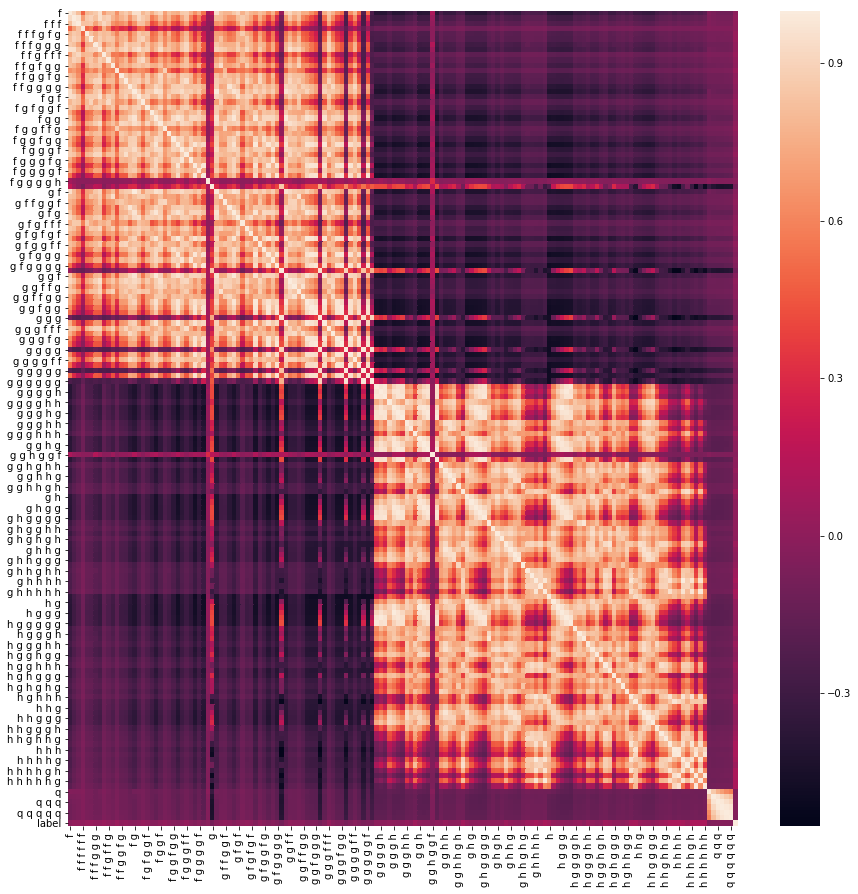

In [172]:
plt.rcParams['figure.figsize']=(15,15)
sns.heatmap(df_tfidf[selected_features+['label']].corr())

In [159]:
df_tfidf['label'].describe()

count      1374
unique        2
top       False
freq       1027
Name: label, dtype: object

In [167]:
plt.rcParams['figure.figsize']=(12,6)

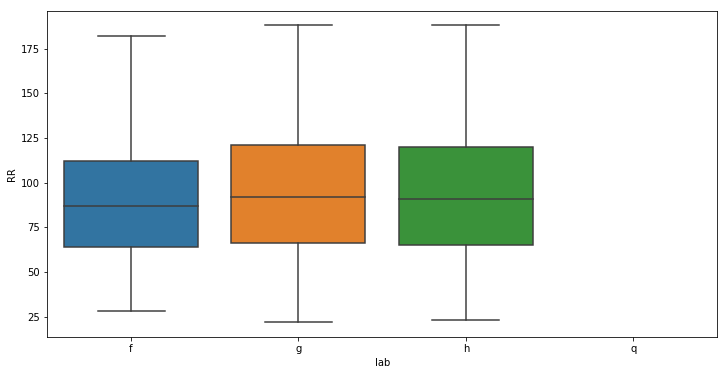

In [168]:
sns.boxplot(x="lab",y="RR", data=no_dups[no_dups.lab.isin(['f','g','h','q'])],order=['f','g','h','q'])

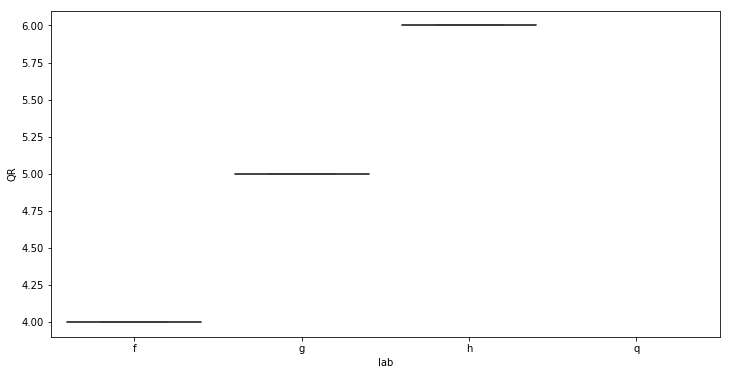

In [169]:
sns.boxplot(x="lab",y="QR", data=no_dups[no_dups.lab.isin(['f','g','h','q'])],order=['f','g','h','q'])

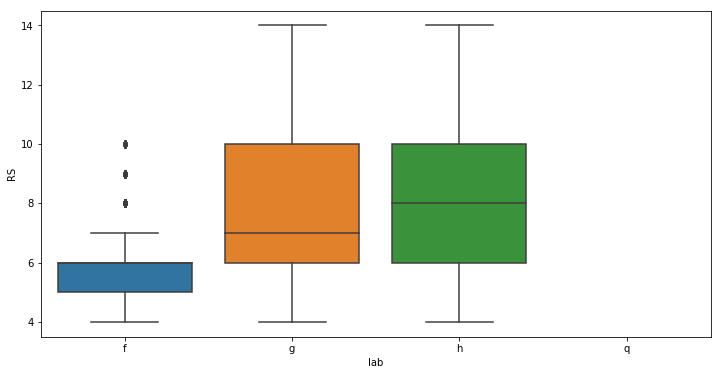

In [170]:
sns.boxplot(x="lab",y="RS", data=no_dups[no_dups.lab.isin(['f','g','h','q'])],order=['f','g','h','q'])

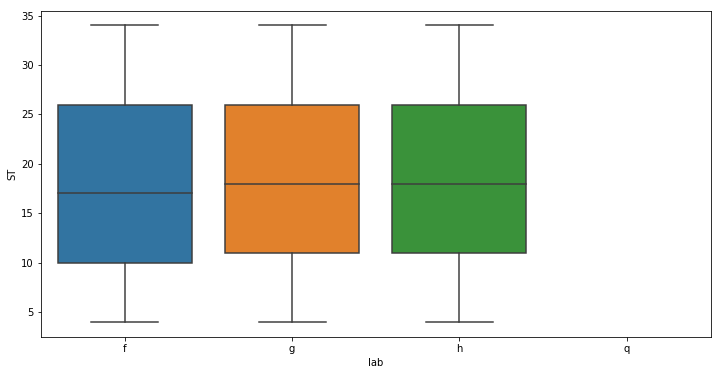

In [171]:
sns.boxplot(x="lab",y="ST", data=no_dups[no_dups.lab.isin(['f','g','h','q'])],order=['f','g','h','q'])